# An Optical Flow-based Symbol Recognition Method

<span style="color: red;">TODO: Megnézni más címeket is példának!</span>

Journal: http://scientificbulletin.upm.ro/?pag=submit

**Keywords**: Human Computer Interaction, Augmented Reality

**Abstract**: Symbol recognizer instead of a full OCR.

## Introduction

The research of the proper human-computer interaction is one of the fundamental problems of computer science.
The motivation behind them is to find the most natural way of the communication with the help of machines.
The increasing number of Augmented Reality and Virtual Reality applications signs the relevance and actuality of the presented topic.

The goal of this paper is to provide an alternative method for solving the symbol recognition problem where the input is a video stream.
In the considered scenario the user draws various symbols into the air in front of the camera.
There is a set of predefined symbols.
We have to provide an image processing method and a classification algorithm which can guess the symbol with sufficient accuracy.

The proposed symbol recognition method uses motion flow information for estimating the recently drawn symbols.
Compared to the classical object tracking methods it has the following advantages and disadvantages.

The main benefit of this approach is the shape and texture invariance.
Most of the available methods combines shape detection and object tracking techniques [].
Therefore, the reliability of the symbol recognition depends on the accuracy of these two different steps.

An object detection and a pose estimation method can provide detailed information about the tracked object.
In our use case these informations are ignored.
It means that, our system is unable to differentiate between a human hand and an arbitrary pointer device on the images.

[DTW-s cikk]

## Video stream processing method

The processing of the video stream is a multistep process.
The video stream is the sequence of coloured images.
We call these images as frames.
The format and the resolution of all frames are the same.
The elapsed time between two sequential frames can be considered as a constant value, denoted by $\Delta t$.
Let see the overview of the proposed method in Figure [].
We describe the details of the processing steps in the following subsections.

<span style="color: red;">TODO: Összerakni egy áttekintő ábrát a feldolgozási folyamatról!</span>

<img src="./docs/images/processing-flow/processing-flow.png" width="80%">

### Image proprocessing

We consider only that cases, where the hue of objects on the images do not provide significant additional information in the aspect of symbol recognition.
Our experiment suggest that the usage of grayscale images is sufficient.
There are different methods for the grayscale convertion.
The selection of them does not play key role in the further processing steps.

We would like to reduce the effect of light condition changes.
Some of the video capturing devices have capability to adapt to them.
It helps to improve the image quality in the typical use case, but also means that any local intensity changes affect intensity changes globally.
Fortunately, the estimation of motion vectors will eliminate this kind of noise automatically.

### Motion vector field estimation

On sequential frames we can observe that some regions of the image are changing their positions.
It does not necessarily match with the real position changes of the objects of the captured scene.
Theoretically, it is possible to estimate the motion vector for any point of a frame.
Therefore, it results a vector field on the domain of the image.

The presented symbol recognition method based on the estimation of these motion vectors.
The following paragraphs mention the reasons which makes the estimation task difficult.

The *motion* is not a well-defined term in this consideration.
It is an intuitive concept without a strict mathematical foundation.

The estimation of a motion vector at a point requires the current frame and at least the previous one.
On the analogy of interpolation methods, we could take into account more preceding frames.
Expectedly, more frames are unable to cause significantly better classification accuracy.

The frames are rasterized images.
Smaller number of motion vectors is enough.

We have to select the tracked parts of the image.
All parts should have exactly the same shape and size.
The segmentation of the image by a squared grid is appropriate.
Moreover, it provides a more convenient calculation scheme.

The OpenCV library contains the implementation of an optical flow method of Lucas-Kanade [].
We use an equidistant squared grid on the image.
* The grid size is a free parameter of the method.
* The window size is $50 \times 50$.
* We have choosed the maximal level of the image pyramid to 2.
* The iterative search process termination criteria is $\varepsilon = 0.03$ and the maximal count of iteration steps is 10.

The implementation details of the algorithm and the tuning of proper parametrization is out of the scope of our current research.

<span style="color: red;">TODO: Készíteni egy ábrát a rácsról!</span>

<img src="./docs/images/grid/grid.png" width="50%">

### Heat map calculation

The estimated motion vectors describe the drawed symbol in time intervals with $\Delta t$ lengths.
For higher level view we have to aggregate the vector fields.
A straightforward method of the aggregation is the usage of matrix which resembles to a heat map.

Let consider only the measure of the motions which is available as the lengths of motion vectors.
Let denote $l_i \in \mathbb{R}$ the length of a motion vector of the $i$-th frame.
Let denote $h_i \in \mathbb{R}$ the *heat value* on the $i$-th frame.

$$
l_i, l_{i-1}, l_{i-2}, \ldots, l_{i-k}
$$
We can use a $k+1$ sized convolution kernel.
$C: \mathbb{R}^{k+1} \rightarrow \mathbb{R}$

We would like to find a proper aggregator function $f: \mathbb{R}^2 \rightarrow \mathbb{R}$ as
$$
h_i = f(h_{i-1}, l_i).
$$

It requires a time window.

<span style="color: red;">TODO: Készíteni képet egy hőtérképről!</span>

<img src="./docs/images/heatmap/heatmap.png" width="50%">

### Temporal filter for Symbol Canvas

The length of the drawed symbols can be differ significantly.
The following approaches can be applied for solving this issue.

* Usage of lower level primitives, for instance curves.
* Define a temporal filter which is able to detect the begin and end of the symbol drawing process.

We prefer to use the latter, because on successful time segment detection the symbol recognition task becomes the classical pattern recognition problem.

By using the temporal filter, we obtain the snapshots of the heatmap where the symbols can be classified and it also makes possible to clear the heatmap after a symbol has drawn.
We apply an experimental motion measure threshold (denoted by $\mu$) and time limit (denoted by $\tau$) for clearing the canvas.

### Symbol recognizer

We define the ideal patterns in the resolution of the grid.
These are the reference patterns.
We calculate the sum of squared distances of pixel intensities.
We select the reference image where this sum is minimal.

## Results

For checking the effectiveness of the proposed method, we define six symbols (Fig. 3).
We have recorded six videos with at least 4 occurrences of them.

In [1]:
import sys
import os
sys.path.append('../program/')

os.listdir()

['draft.ipynb',
 'paper.bib',
 'docs',
 'tmp',
 '.ipynb_checkpoints',
 'AMSET_Author_template.docx']

In [11]:
import numpy as np

from arpt.frame_buffer import FrameBuffer
from arpt import motion_field
from arpt.video import Video

symbol_names = [
    'circle', 'square', 'triangle', 'nabla', 'plus', 'x'
]

# symbol_names = [
#     'nabla'
# ]

measures = {}

for symbol_name in symbol_names:
    frames = FrameBuffer()
    measures[symbol_name] = []
    with Video(f'./tmp/arpt/videos/{symbol_name}.webm') as video:
        while True:
            frame = video.get_next_frame()
            # print(frame.shape)
            if frame is None:
                break
            frames.push_frame(frame)
            motion_vectors = motion_field.calc_optical_flow(frames[-1], frames[0], (18, 24))
            lengths = motion_field.calc_lengths(motion_vectors)
            measure = np.mean(np.mean(lengths))
            measures[symbol_name].append(measure)

    frames = FrameBuffer()
    with Video(f'./tmp/arpt/videos/{symbol_name}_test.mp4') as video:
        while True:
            frame = video.get_next_frame()
            # print(frame.shape)
            if frame is None:
                break
            frames.push_frame(frame)
            motion_vectors = motion_field.calc_optical_flow(frames[-1], frames[0], (18, 24))
            lengths = motion_field.calc_lengths(motion_vectors)
            measure = np.mean(np.mean(lengths))
            measures[symbol_name].append(measure)


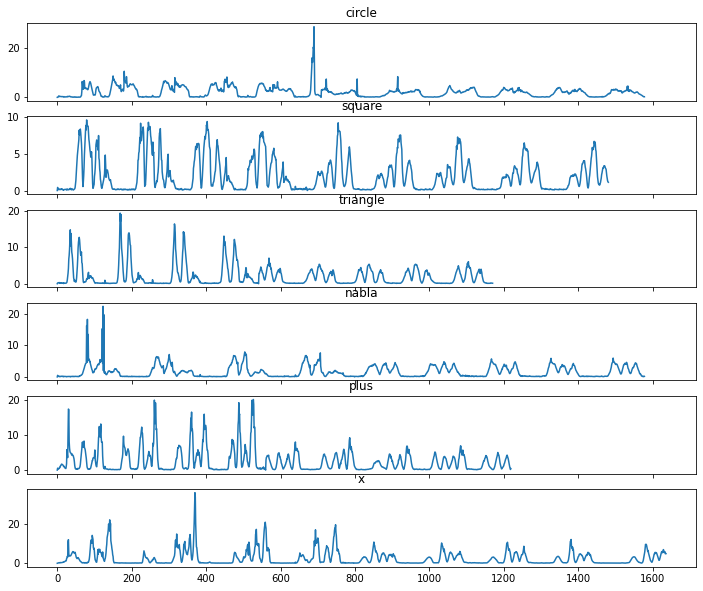

In [12]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(6, figsize=(12, 10), sharex=True)
for i, symbol_name in enumerate(symbol_names):
    axs[i].plot(measures[symbol_name])
    axs[i].set_title(symbol_name)

The grid is 18 rows and 24 columns

In [14]:
heat_maps = {}

for symbol_name in symbol_names:
    frames = FrameBuffer()
    heat_map = np.zeros((18, 24), dtype=np.float32)
    with Video(f'./tmp/arpt/videos/{symbol_name}.webm') as video:
        while True:
            frame = video.get_next_frame()
            if frame is None:
                break
            frames.push_frame(frame)
            motion_vectors = motion_field.calc_optical_flow(frames[-1], frames[0], (18, 24))
            
            lengths = motion_field.calc_lengths(motion_vectors)
            # heat_map = np.maximum(heat_map, lengths)
            heat_map += lengths
            
    frames = FrameBuffer()
    with Video(f'./tmp/arpt/videos/{symbol_name}_test.mp4') as video:
        while True:
            frame = video.get_next_frame()
            if frame is None:
                break
            frames.push_frame(frame)
            motion_vectors = motion_field.calc_optical_flow(frames[-1], frames[0], (18, 24))
            
            lengths = motion_field.calc_lengths(motion_vectors)
            # heat_map = np.maximum(heat_map, lengths)
            heat_map += lengths
    heat_maps[symbol_name] = heat_map

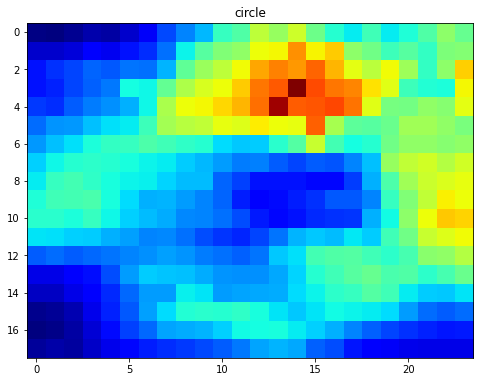

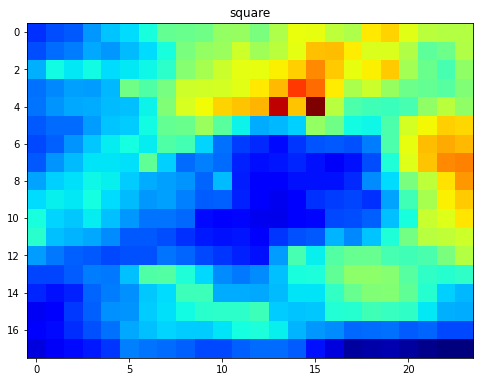

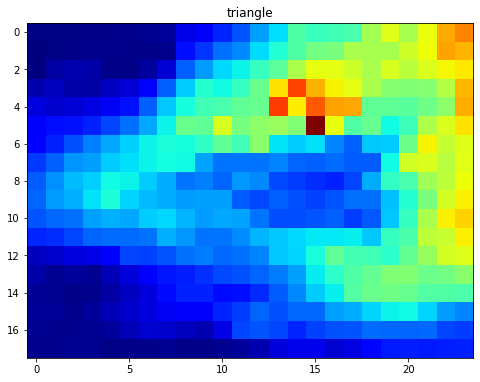

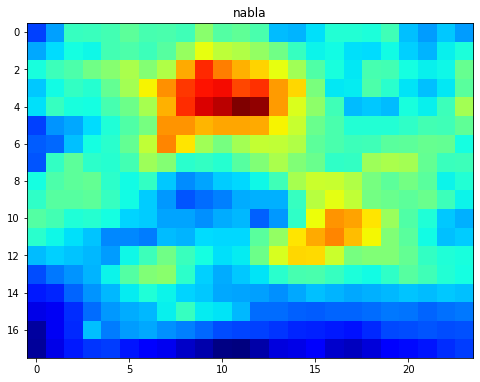

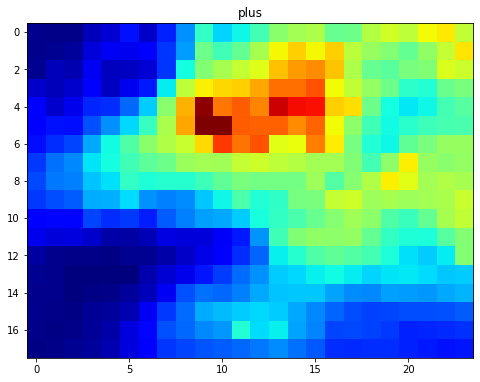

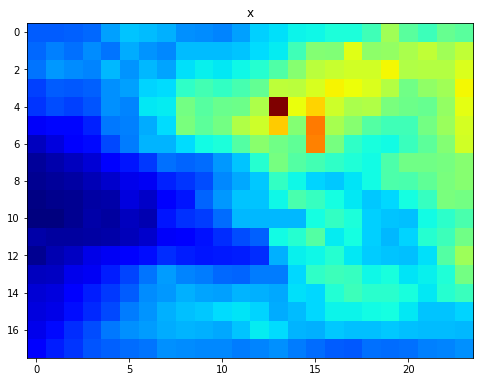

In [15]:
for symbol_name in symbol_names:
    figure = plt.figure(figsize=(8, 8))
    heat_map = heat_maps[symbol_name] / np.max(np.max(heat_maps[symbol_name]))
    plt.imshow(heat_map, cmap='jet', interpolation='nearest')
    plt.title(symbol_name)
    plt.show()

In [16]:
MU = 2
TAU = 40

heat_maps = {}
for symbol_name in symbol_names:
    print(f'{symbol_name} ...')
    frames = FrameBuffer()
    heat_maps[symbol_name] = []
    is_first = True
    with Video(f'./tmp/arpt/videos/{symbol_name}.webm') as video:
        heat_map = np.zeros((18, 24), dtype=np.float32)
        n = 0
        while True:
            frame = video.get_next_frame()
            if frame is None:
                heat_maps[symbol_name].append(heat_map)
                break
            frames.push_frame(frame)
            motion_vectors = motion_field.calc_optical_flow(frames[-1], frames[0], (18, 24))
            lengths = motion_field.calc_lengths(motion_vectors)
            measure = np.mean(np.mean(lengths))
            if measure > MU:
                heat_map += lengths
                if n > TAU:
                    if is_first is True:
                        is_first = False
                    else:
                        heat_maps[symbol_name].append(heat_map)
                    heat_map = np.zeros((18, 24), dtype=np.float32)
                    n = 0
            else:
                n += 1

    frames = FrameBuffer()    
    with Video(f'./tmp/arpt/videos/{symbol_name}_test.mp4') as video:
        heat_map = np.zeros((18, 24), dtype=np.float32)
        n = 0
        while True:
            frame = video.get_next_frame()
            if frame is None:
                heat_maps[symbol_name].append(heat_map)
                break
            frames.push_frame(frame)
            motion_vectors = motion_field.calc_optical_flow(frames[-1], frames[0], (18, 24))
            lengths = motion_field.calc_lengths(motion_vectors)
            measure = np.mean(np.mean(lengths))
            if measure > MU:
                heat_map += lengths
                if n > TAU:
                    if is_first is True:
                        is_first = False
                    else:
                        heat_maps[symbol_name].append(heat_map)
                    heat_map = np.zeros((18, 24), dtype=np.float32)
                    n = 0
            else:
                n += 1


circle ...
square ...
triangle ...
nabla ...
plus ...
x ...


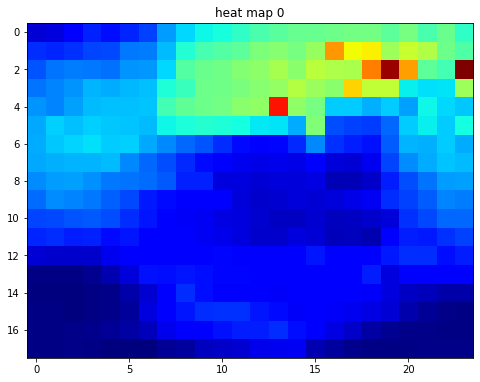

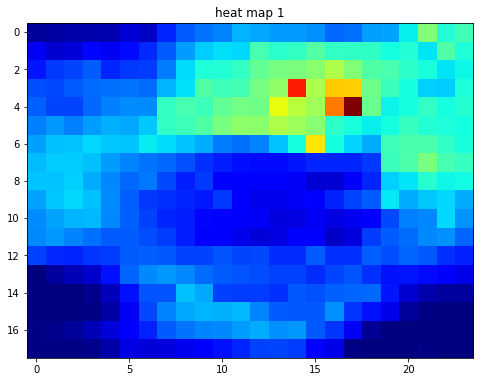

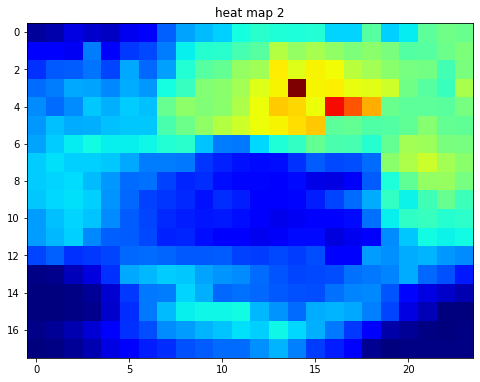

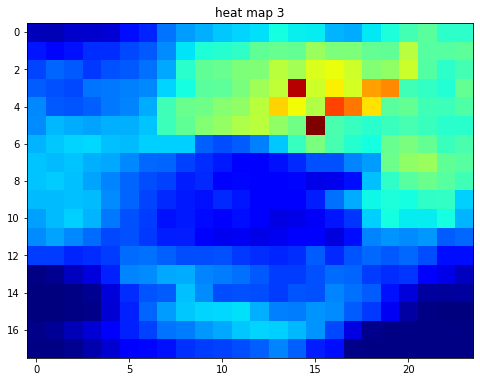

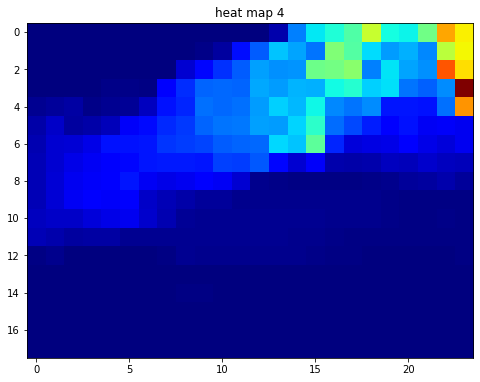

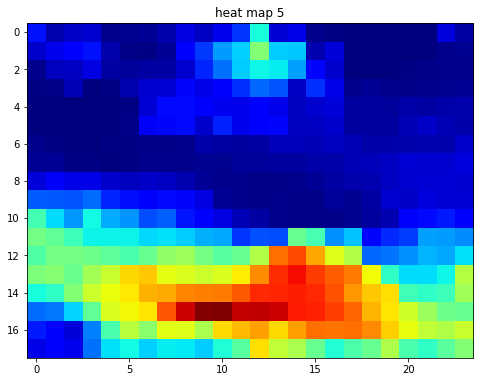

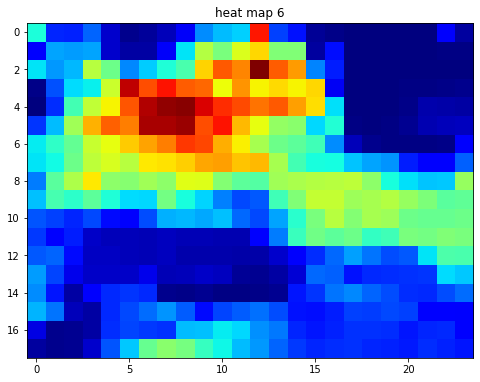

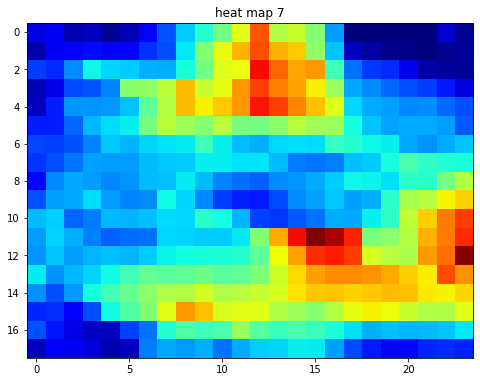

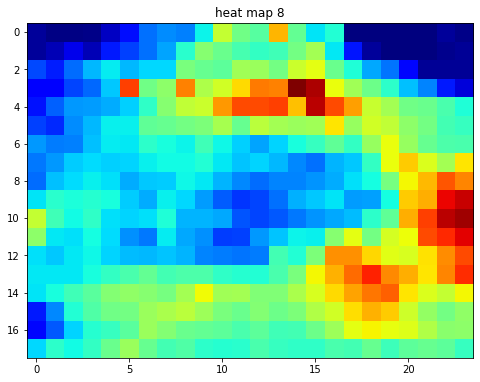

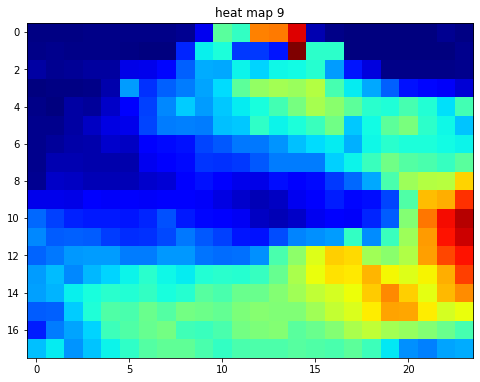

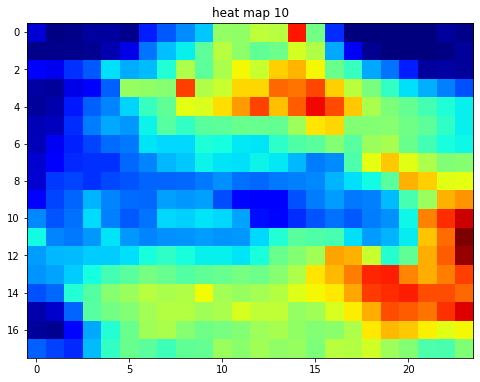

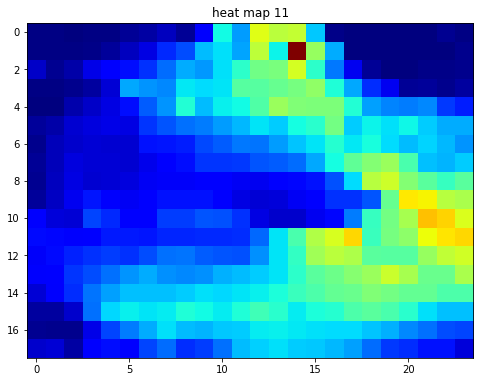

In [17]:
for i, heat_map in enumerate(heat_maps['circle']):
    figure = plt.figure(figsize=(8, 8))
    plt.imshow(heat_map, cmap='jet', interpolation='nearest')
    plt.title(f'heat map {i}')
    plt.show()

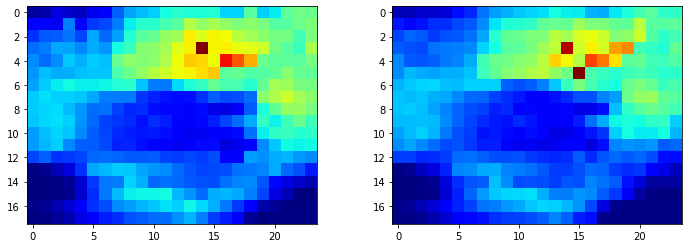

In [8]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharex=True)
axs[0].imshow(heat_maps['circle'][2], cmap='jet', interpolation='nearest')
axs[1].imshow(heat_maps['circle'][3], cmap='jet', interpolation='nearest')

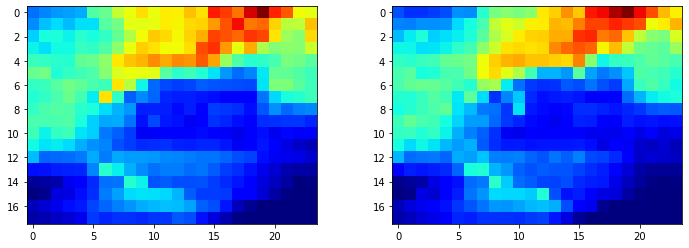

In [9]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharex=True)
axs[0].imshow(heat_maps['square'][2], cmap='jet', interpolation='nearest')
axs[1].imshow(heat_maps['square'][3], cmap='jet', interpolation='nearest')

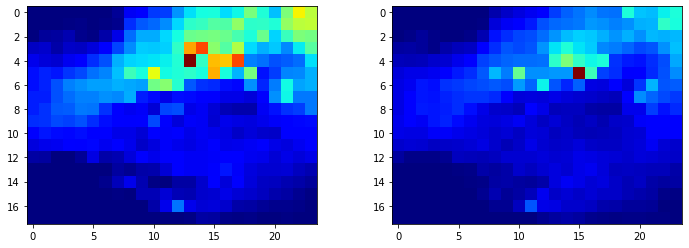

In [10]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharex=True)
axs[0].imshow(heat_maps['triangle'][1], cmap='jet', interpolation='nearest')
axs[1].imshow(heat_maps['triangle'][2], cmap='jet', interpolation='nearest')

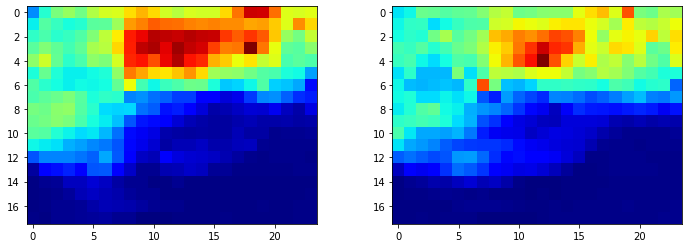

In [11]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharex=True)
axs[0].imshow(heat_maps['nabla'][1], cmap='jet', interpolation='nearest')
axs[1].imshow(heat_maps['nabla'][3], cmap='jet', interpolation='nearest')

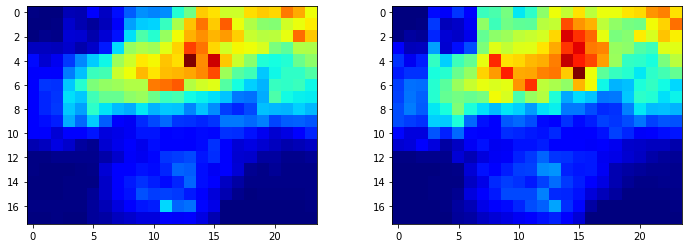

In [12]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharex=True)
axs[0].imshow(heat_maps['plus'][2], cmap='jet', interpolation='nearest')
axs[1].imshow(heat_maps['plus'][3], cmap='jet', interpolation='nearest')

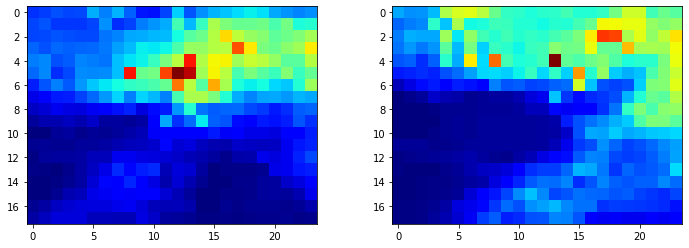

In [13]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharex=True)
axs[0].imshow(heat_maps['x'][2], cmap='jet', interpolation='nearest')
axs[1].imshow(heat_maps['x'][3], cmap='jet', interpolation='nearest')

Making dataset from datas, need more data!!!

In [41]:
X = np.empty((0, 18*24), dtype=np.float32)
y = np.empty((0, ), dtype=np.uint8)
labels = symbol_names

for gesture in heat_maps:
    for heat_map in heat_maps[gesture]:
        feature_vector = np.array(heat_map).flatten()
        X = np.append(X, [feature_vector], axis=0)
        y = np.append(y, [gesture], axis=0)

Preprocessing the data

In [42]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(X)

scaled_X = scaler.transform(X)

print(len(y))
print(np.mean(X))
print(np.mean(scaled_X))

64
240.32727
4.415159e-09


Splitting dataset to train and test sets

In [43]:
from sklearn.model_selection import train_test_split

TEST_SIZE = 0.3
SEED = 7

X_train, X_test, Y_train, Y_test = \
    train_test_split(scaled_X, y,
                     test_size=TEST_SIZE,
                      random_state=SEED)

print("Training dataset size:", len(Y_train))
print("Testing dataset size:", len(Y_test))

Training dataset size: 44
Testing dataset size: 20


Fitting the dataset to estimator

In [44]:
from sklearn.ensemble import RandomForestClassifier

classifier_args = dict(random_state=42)
clf = RandomForestClassifier(**classifier_args)
clf.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

Making fonfusion matrix from the test set

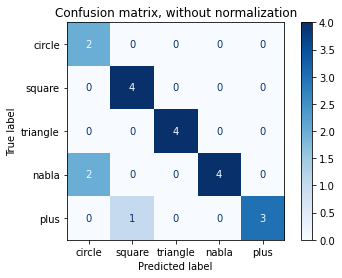

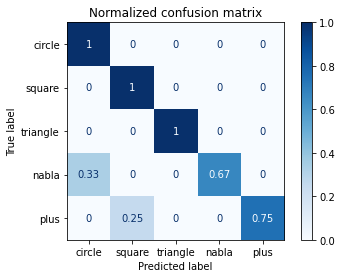

In [45]:
from sklearn.metrics import plot_confusion_matrix

titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(clf, X_test, Y_test,
                                 display_labels=labels,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

plt.show()

3 seconds limit ..when the average motion is under a specified limit.

### Symbol selection

In this section we overview the different kind of noises.
Light equalization

movement noise reduction

## Discussion

As an improved solution we could use Artificial Neural Networks for symbol detection.
it is a further

## Conclusions

## Acknowledgement

<span style="color: red;">TODO: Rakaczki Csabát megkérdezni, hogy kell-e bele ilyesmi!</span>

## References

20 items